In [1]:
import os
import random

import numpy as np
import pandas as pd
import torch

sorted_dates = ['2019-05-06', '2019-05-07', '2019-05-08', '2019-05-09', '2019-05-10',
                '2019-05-11', '2019-05-12', '2019-05-13', '2019-05-14', '2019-05-15',
                '2019-05-16', '2019-05-17', '2019-05-18', '2019-05-19']
start_day = 1
end_day = start_day + len(sorted_dates)
start_date = sorted_dates[start_day - 1]  # Day count indexed from 1
end_date = sorted_dates[end_day - 2]

total_edges = 10000

seed = 45215
torch.manual_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed = seed
np.seed = seed
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

positive_data = pd.read_csv(f'data/preprocessed/averaged_ks_scores/top_{total_edges}.csv')
negative_data = pd.read_csv(f'data/preprocessed/averaged_ks_scores/negative_top_{total_edges}.csv')
complete_data_fp = f'data/preprocessed/averaged_ks_scores/complete_graph_top_{total_edges}.csv'
complete_data = pd.read_csv(complete_data_fp)

print(f'Edge Count for Positive Samples: {positive_data.shape[0]} edges')
print(f'Edge Count for Negative Samples: {negative_data.shape[0]} edges')
print(f'Edge Count for All Samples: {complete_data.shape[0]} edges')

print(f'Days in Positive Data: {sorted(positive_data["day"].unique())}')
print(f'Days in Negative Data: {sorted(negative_data["day"].unique())}')
print(f'Days in Complete Data: {sorted(complete_data["day"].unique())}')

Edge Count for Positive Samples: 11440 edges
Edge Count for Negative Samples: 4298356 edges
Edge Count for All Samples: 4309796 edges
Days in Positive Data: [1, 2]
Days in Negative Data: [1, 2]
Days in Complete Data: [1, 2]


In [1]:
from compute_features import compute_transaction_features, read_silences
from kolmogorov_smirnov import get_ks_nodes, get_top_n_edges

ks_nodes = get_ks_nodes(complete_data_fp, start_day, end_day)
top_n_edges = get_top_n_edges(total_edges, complete_data_fp)

tx_node_features = compute_transaction_features('data/transactions/', ks_nodes, start_day, end_day, start_date, total_edges)
silence_distributions = read_silences('data/preprocessed/daily_silences/', ks_nodes, start_day, end_day)

NameError: name 'complete_data_fp' is not defined

In [3]:
low_training_ks_threshold = 0.001
high_training_ks_threshold = 0.98

pos_training_data = positive_data[positive_data['ks_dist'] <= low_training_ks_threshold].reset_index(drop=True).copy()
positive_nodes_by_day = positive_data.groupby('day')['normalized_edge'].apply(
    lambda edges: set(node for edge in edges for node in eval(edge))
).to_dict()
positive_samples_count_by_day = pos_training_data.groupby('day').size().to_dict()

neg_training_data = negative_data[
    negative_data.apply(
        lambda row: frozenset(eval(row['normalized_edge'])) <= positive_nodes_by_day[row['day']], axis=1)
].reset_index(drop=True)
negative_training_data = neg_training_data[neg_training_data['ks_dist'] > high_training_ks_threshold].reset_index(drop=True).copy()

positive_training_data = positive_data.copy()

print(f'Low KS Dist. Edges Count: {positive_training_data.shape[0]}')
print(f'High KS Dist. Edges Count: {negative_training_data.shape[0]}')

Low KS Dist. Edges Count: 11923
High KS Dist. Edges Count: 23947


In [4]:
from torch_geometric_temporal.signal import temporal_signal_split
from compute_features import get_scaled_node_features, get_silence_dist_features
from snapshot_generation import generate_snapshots

feature_count = 34

all_addresses = pd.unique(pd.concat([
    positive_data['unique_from'],
    positive_data['unique_to'],
], ignore_index=True))
np.random.shuffle(all_addresses)  # In-place

address_to_node_idx = {a: idx for idx, a in enumerate(all_addresses)}
node_idx_to_address_map = {v: k for k, v in address_to_node_idx.items()}

silence_dist_node_features = get_silence_dist_features(silence_distributions, all_addresses, start_day, end_day)
scaled_node_features = get_scaled_node_features(silence_dist_node_features, tx_node_features, start_day, end_day)

pos_dataset = generate_snapshots(
    pos_training_data, address_to_node_idx, scaled_node_features, feature_count, start_day, end_day, False)
neg_dataset = generate_snapshots(
    neg_training_data, address_to_node_idx, scaled_node_features, feature_count, start_day, end_day, True)

pos_train_dataset, pos_val_dataset = temporal_signal_split(pos_dataset, train_ratio=0.80)
neg_train_dataset, neg_val_dataset = temporal_signal_split(neg_dataset, train_ratio=0.80)

print(f'Total Node Count: {len(address_to_node_idx)}')
print(f'Positive Training Snapshot Count: {pos_train_dataset.snapshot_count}')
print(f'Negative Training Snapshot Count: {neg_train_dataset.snapshot_count}')
print(f'Positive Validation Snapshot Count: {pos_val_dataset.snapshot_count}')
print(f'Negative Validation Snapshot Count: {neg_val_dataset.snapshot_count}')

Missing Node Count: 0
Total Node Count: 3280
Positive Training Snapshot Count: 11
Negative Training Snapshot Count: 11
Positive Validation Snapshot Count: 2
Negative Validation Snapshot Count: 2


In [5]:
pos_edges_count = 0
for snapshot in pos_train_dataset:
    pos_edges_count += snapshot.y.sum().item()

neg_edges_count = 0
for snapshot in neg_train_dataset:
    neg_edges_count += len(snapshot.y[snapshot.label == 0])
    
print(f'Positive Edges: {pos_edges_count}, Negative Edges: {neg_edges_count}')

Positive edges: 1402.0, Negative edges: 39700


Starting run 1...
Epoch 00014: reducing learning rate of group 0 to 1.0000e-04.
Epoch 00018: reducing learning rate of group 0 to 1.0000e-05.
Ranking 146 pairs...


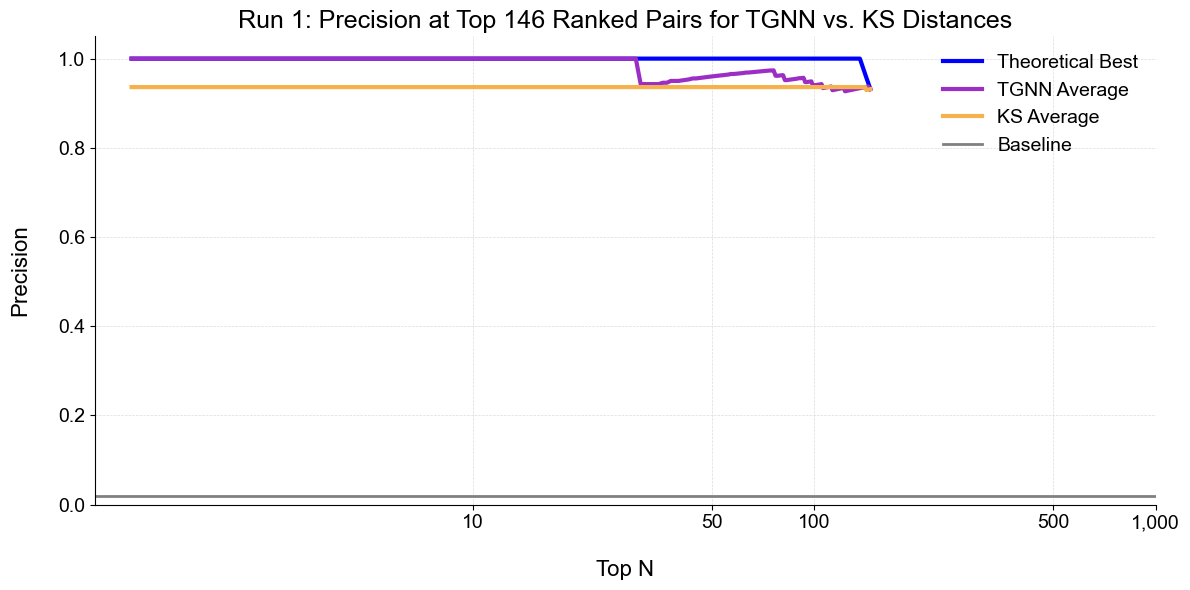

Starting run 2...
Epoch 00016: reducing learning rate of group 0 to 1.0000e-04.
Epoch 00020: reducing learning rate of group 0 to 1.0000e-05.
Ranking 146 pairs...


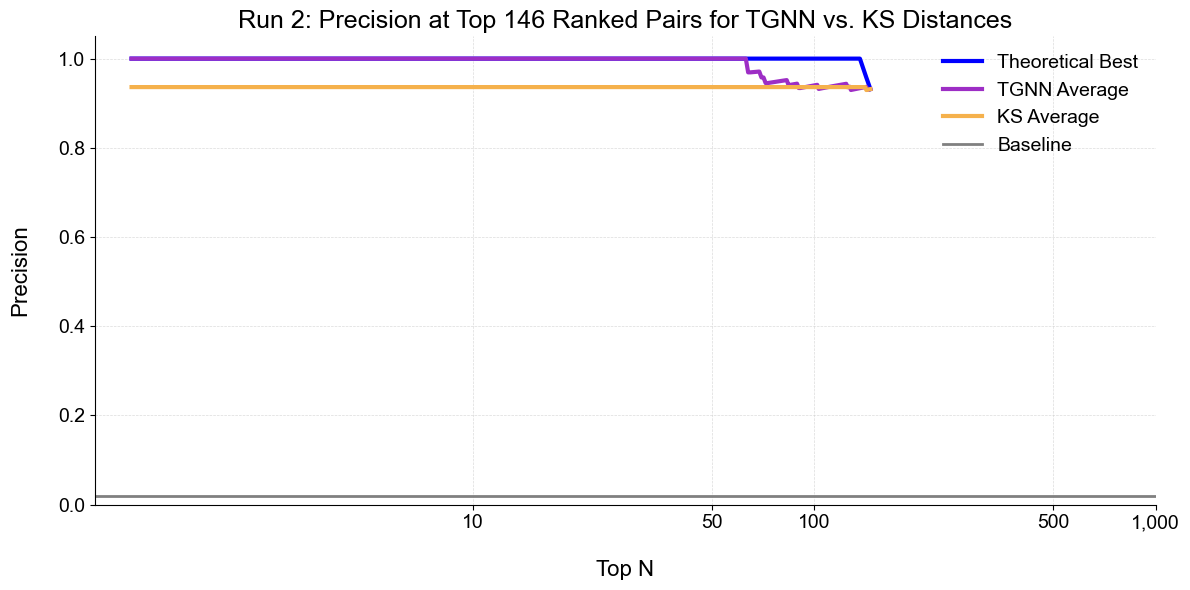

Starting run 3...
Epoch 00018: reducing learning rate of group 0 to 1.0000e-04.
Epoch 00022: reducing learning rate of group 0 to 1.0000e-05.
Ranking 146 pairs...


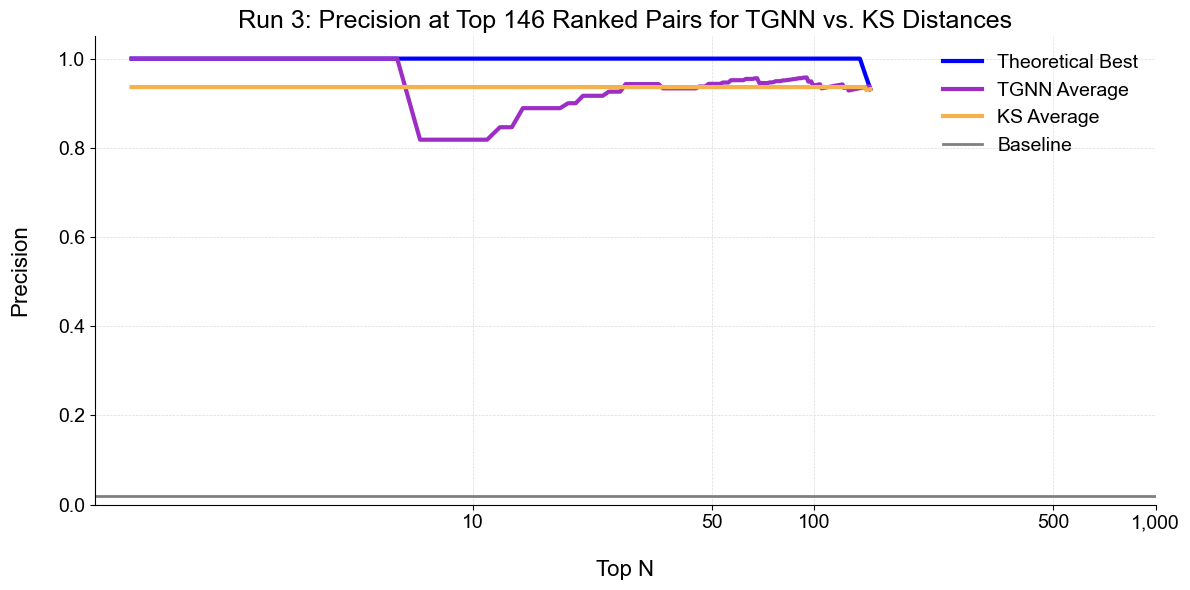

Starting run 4...
Epoch 00013: reducing learning rate of group 0 to 1.0000e-04.
Epoch 00017: reducing learning rate of group 0 to 1.0000e-05.
Ranking 146 pairs...


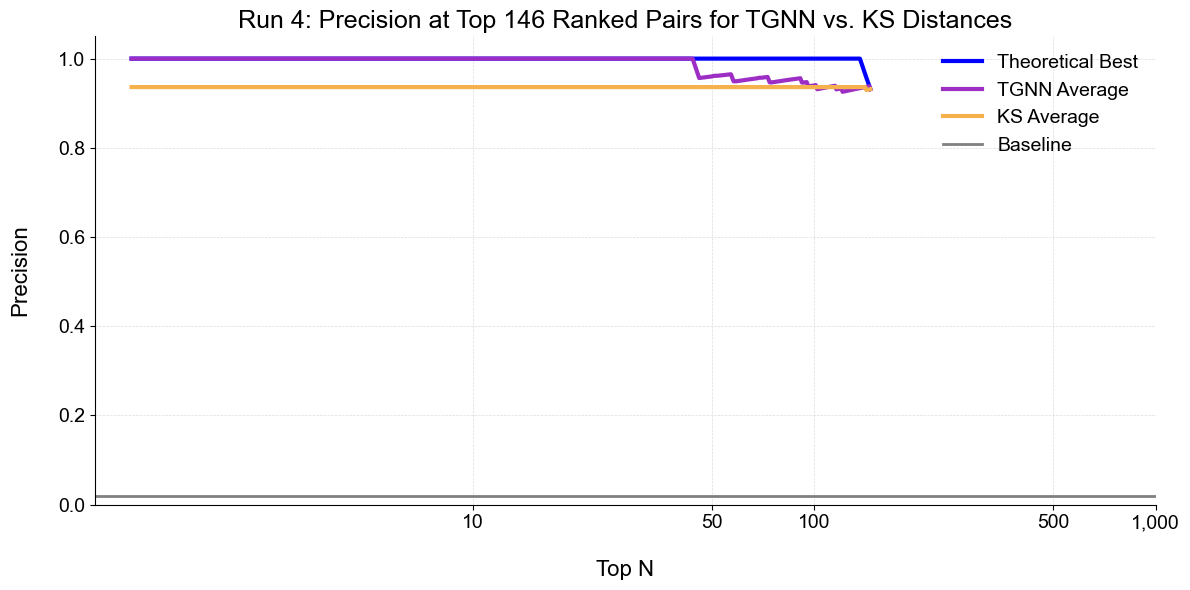

Starting run 5...
Epoch 00009: reducing learning rate of group 0 to 1.0000e-04.
Epoch 00013: reducing learning rate of group 0 to 1.0000e-05.
Ranking 146 pairs...


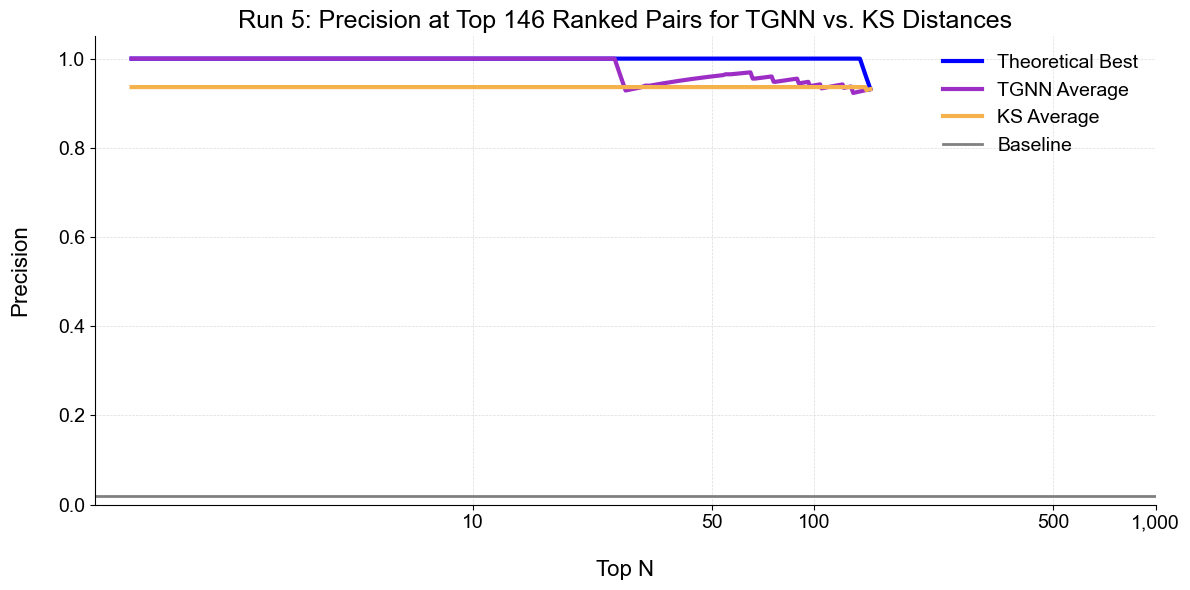

Starting run 6...
Epoch 00009: reducing learning rate of group 0 to 1.0000e-04.
Epoch 00013: reducing learning rate of group 0 to 1.0000e-05.
Ranking 146 pairs...


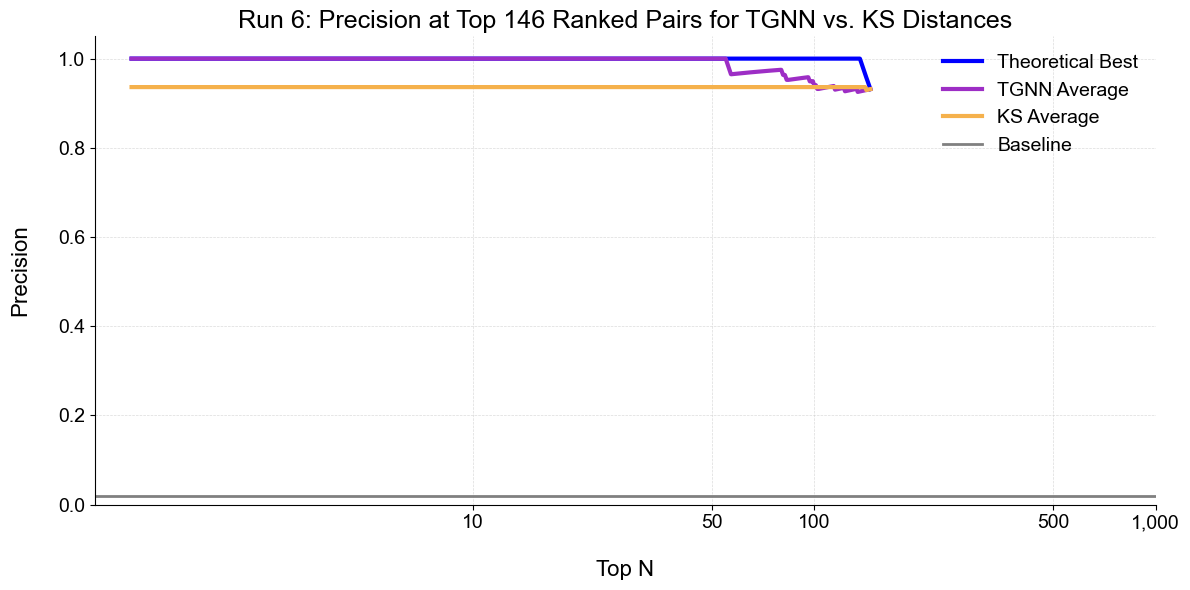

Starting run 7...
Epoch 00009: reducing learning rate of group 0 to 1.0000e-04.
Epoch 00013: reducing learning rate of group 0 to 1.0000e-05.
Ranking 146 pairs...


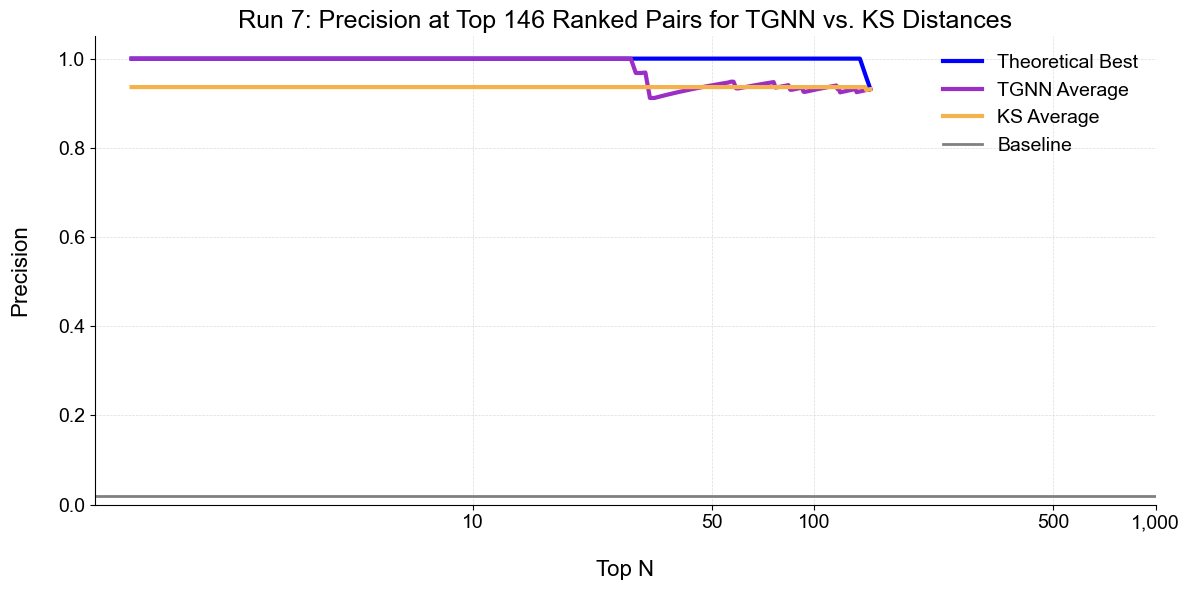

Starting run 8...
Epoch 00007: reducing learning rate of group 0 to 1.0000e-04.
Epoch 00011: reducing learning rate of group 0 to 1.0000e-05.
Ranking 146 pairs...


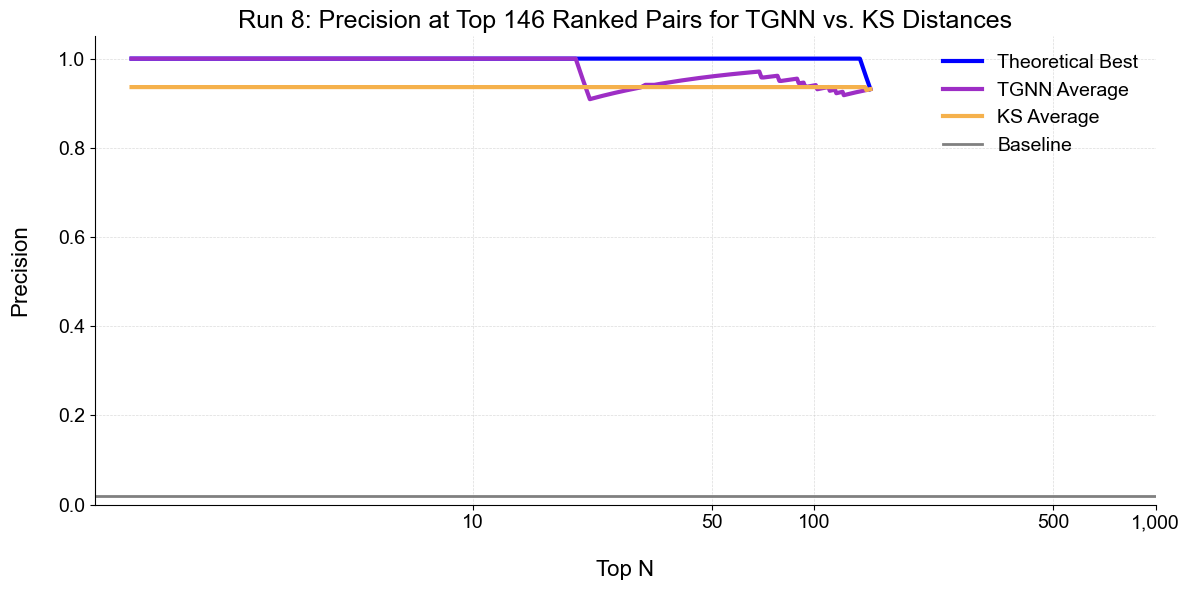

Starting run 9...
Epoch 00017: reducing learning rate of group 0 to 1.0000e-04.
Epoch 00021: reducing learning rate of group 0 to 1.0000e-05.
Ranking 146 pairs...


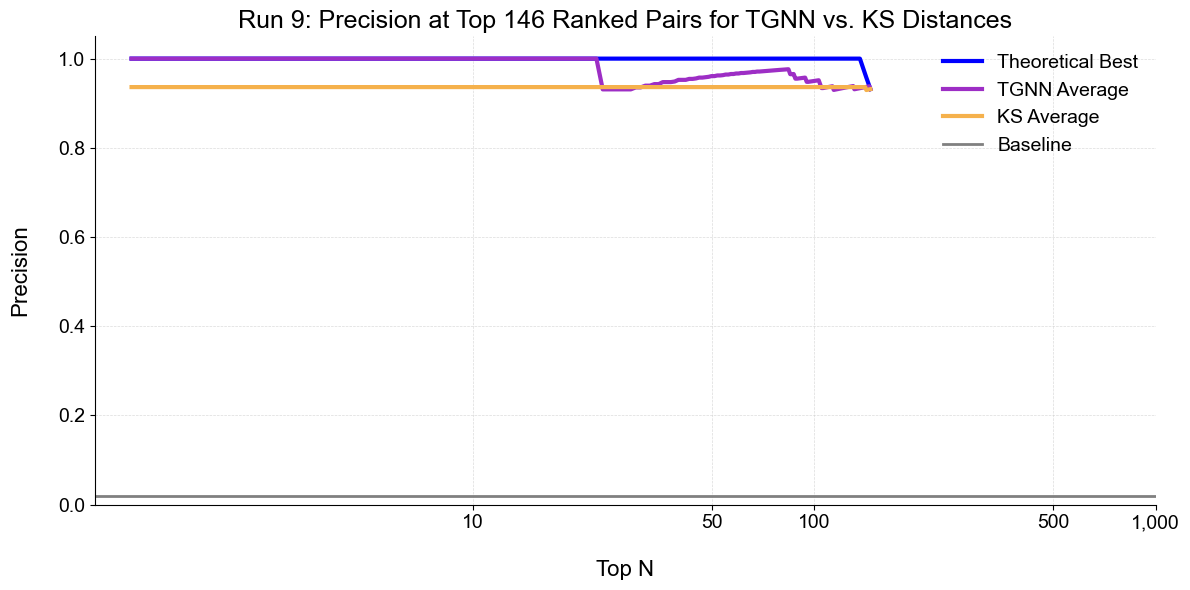

Starting run 10...
Epoch 00008: reducing learning rate of group 0 to 1.0000e-04.
Ranking 146 pairs...


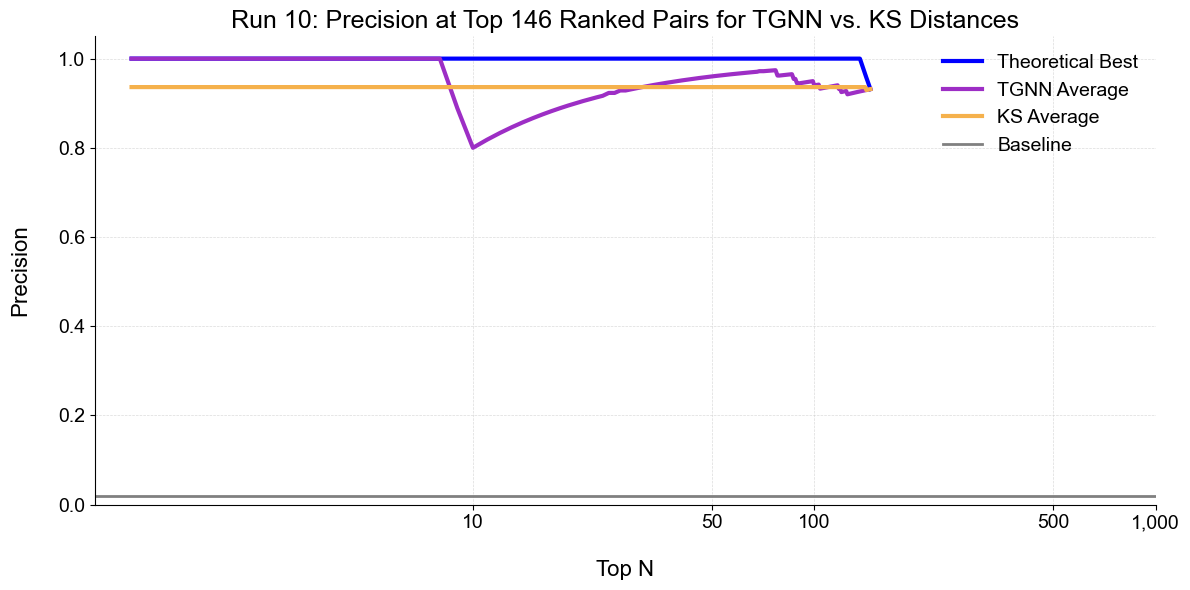

In [13]:
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

from tgnn import TemporalGNN, train, val
from evaluation import get_edge_probabilities 
from data_io import write_results
from plotting import plot_precision_at_top_k

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

pos_weight = neg_edges_count / pos_edges_count
pos_weight = torch.tensor([pos_weight]).to(device)
neg_weight = 1 / pos_weight

patience = 10  # Patience for early stopping

eval_num_days = end_day - start_day

num_runs = 10
for run in range(1, num_runs + 1):
    print(f'Starting run {run}...')
    model = TemporalGNN(node_features=feature_count, hidden_dim=64, embedding_dim=32)
    
    adam_optimizer = Adam(model.parameters(), lr=0.001)
    scheduler = ReduceLROnPlateau(adam_optimizer, mode='min', factor=0.1, patience=3, verbose=True)

    checkpoint_path = f'checkpoint_model_training_run_{run}.pth'
    
    best_loss = float('inf')
    epochs_no_improve = 0
    checkpoint_epoch = 0
    epoch = 0
    for epoch in range(100):
        train_loss = train(model, pos_train_dataset, neg_train_dataset, adam_optimizer, pos_weight, neg_weight, device)
        val_loss = val(model, pos_val_dataset, neg_val_dataset, pos_weight, neg_weight, device)
        if round(val_loss, 3) < round(best_loss, 3):
            best_loss = val_loss
            epochs_no_improve = 0
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': adam_optimizer.state_dict(),
                'loss': best_loss,
            }, checkpoint_path)
            checkpoint_epoch = epoch
        else:
            epochs_no_improve += 1

        if epochs_no_improve == patience:
            break

        scheduler.step(val_loss)
    
    model = TemporalGNN(node_features=feature_count, hidden_dim=64, embedding_dim=32)
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])

    low_eval_ks_threshold = 0.001
    high_eval_ks_threshold = 0.02616
    
    valid_edges = {(u, v) for u, v, score in top_n_edges 
                   if low_eval_ks_threshold < score <= high_eval_ks_threshold}
    valid_edges_str = {str(edge) for edge in valid_edges}

    eval_df = positive_data[
        (start_day <= positive_data['day']) & (positive_data['day'] < end_day) &
        (positive_data['normalized_edge'].isin(valid_edges_str)) 
    ].reset_index(drop=True).copy()
    final_classifier_results = get_edge_probabilities(
        eval_df, scaled_node_features, node_idx_to_address_map, model, device, start_day, end_day, feature_count)
   
    # Write TGNN and filtered KS results to file
    tgnn_filename = (f'results/{eval_num_days}_days/tgnn_pairs_{start_date}_to_{end_date}_'
                     f'low_{low_eval_ks_threshold}_high_{high_eval_ks_threshold}_{run}')
    ks_filename = (f'results/{eval_num_days}_days/ks_pairs_{start_date}_to_{end_date}_'
                   f'low_{low_eval_ks_threshold}_high_{high_eval_ks_threshold}.csv')
    write_results(final_classifier_results, top_n_edges, low_eval_ks_threshold, f'{tgnn_filename}.csv', ks_filename)

    # Plot results
    plot_precision_at_top_k(f'{tgnn_filename}.png')